In [1]:
import pandas as pd
import numpy as np
import spacy
import textblob
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import robust
from string import punctuation
import gensim
from gensim.models import word2vec

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Neural Network
from sklearn.neural_network import MLPClassifier

import keras
from keras.optimizers import RMSprop,SGD
from keras.layers import Conv1D,Conv2D, MaxPooling2D,GlobalMaxPooling1D
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.layers import LSTM, Embedding

Using TensorFlow backend.


In [2]:
from dask.distributed import Client, progress
import dask.dataframe as dd
import dask.array as da

In [3]:
import os
# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

## Create Dask Client

In [4]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:56336 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


## Word Embedding - Word2Vec

In [5]:
review = dd.read_csv('boardgame-comments-english.csv').sample(frac=.1,random_state=42)
review = client.persist(review)

In [6]:
review.columns = 'reviewer_id', 'game_id', 'rating', 'comment'

# RATINGS ADJUSTMENT: ceiling >= .5 [or] floor < .5
ratings = da.array(review.rating.round()).compute()

print('Total Comments: {}'.format(len(review.comment)))

Total Comments: 84165


In [7]:
%%time
sentences = da.array(review.comment.apply(lambda val: [b.lower() for b in textblob.TextBlob(val).words])).compute()
beep('ping')

CPU times: user 1.61 s, sys: 477 ms, total: 2.09 s
Wall time: 28 s


In [8]:
%%time
load_model = False

if load_model:
    # # load model
    word_vec = word2vec.Word2Vec.load('full_word2vec_blob.bin')
    vec_size = word_vec.layer1_size
else: 
    vec_size = 50
    word_vec = word2vec.Word2Vec(
        sentences,
        workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
        min_count=5,  # Minimum word count threshold.
        window=6,      # Number of words around target word to consider.
        sg=0,          # Use CBOW because our corpus is small.
        sample=1e-3 ,  # Penalize frequent words.
        size=vec_size,      # Word vector length.
        hs=1           # Use hierarchical softmax.
    )
    
    # save model
    word_vec.save('full_word2vec_blob.bin')

# List of words in model.
vocab = word_vec.wv.vocab.keys()
beep('ping')

CPU times: user 53.6 s, sys: 397 ms, total: 54 s
Wall time: 17.4 s


In [9]:
%%time
vec_new = np.array([.5 for i in range(0,vec_size)])
vectors = da.array(map(lambda val: [word_vec[w] if w in vocab else vec_new for w in val], sentences))
beep('ping')

CPU times: user 48.3 ms, sys: 7.76 ms, total: 56.1 ms
Wall time: 835 ms


### TBD

# 6. Comprehensive Neural Network

In [10]:
%%time
pad, max_words = np.array([0 for i in range(0,vec_size)]), 30

def manual_pad(val):
    empty = max_words-len(val)
    for i in range(0,empty):
        val.append(pad)
    
    return [i for i in val[0:max_words]]

vectors_padding = list(map(manual_pad,vectors))
beep('ping')

CPU times: user 16.6 s, sys: 332 ms, total: 16.9 s
Wall time: 17.7 s


In [11]:
client.close()

Exception ignored in: <generator object add_client at 0x1c28850f10>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 179, in read
    n_frames = yield stream.read_bytes(8)
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/anaconda3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 200, in read
    convert_stream_closed_error(self, e)
  File "/anaconda3/lib/python3.6/site-packages/distributed/comm/tcp.p

In [206]:
%%time
y = np.array(ratings).astype(int).ravel()
X = np.array(vectors_padding)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: user 1.79 s, sys: 1.37 s, total: 3.16 s
Wall time: 3.5 s


In [207]:
XtrSize,XtrMax,XtrVector = X_train.shape
XteSize,XteMax,XteVector = X_test.shape

#### _A - Logistic Regression w/ Vectors_

#### _B - MLP Neural NN w/ Vectors_

#### _C - Keras Sequential NN_

In [208]:
y_test = y_test.ravel()
y_train = y_train.ravel()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [209]:
hidden_size = 500
batch_size = 5
epochs = 1

In [210]:
from keras.layers import Layer,Reshape
import keras.backend as K

class Round(Layer):

    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [249]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=X.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
# model.add(Conv2D(2,2,padding='valid', activation='relu',strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(11, activation='softmax'))
# change output as linear to v

In [251]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [252]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 30, 512)           26112     
_________________________________________________________________
dropout_89 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
dense_117 (Dense)            (None, 30, 512)           262656    
_________________________________________________________________
dropout_90 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 512)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 11)                5643      
Total params: 294,411
Trainable params: 294,411
Non-trainable params: 0
_________________________________________________________________


In [253]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

beep('ping')

Train on 56390 samples, validate on 27775 samples
Epoch 1/1
56390/56390 [==============================] - 135s 2ms/step - loss: 1.9915 - acc: 0.2690 - val_loss: 1.8706 - val_acc: 0.2963


In [254]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.870605527841755
Test accuracy: 0.2962736273466414


In [256]:
from keras.backend import argmax as kargmax

In [257]:
y_predict = np.argmax(model.predict(X_test),axis=1)
final_score = np.argmax(y_test,axis=1)

# final_estimate = model.predict(X_test)
# final_score = y_test

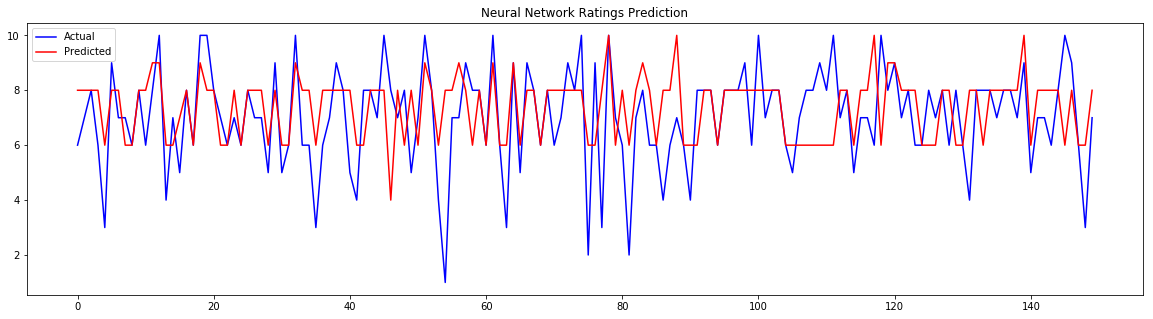

In [258]:
plt.figure(figsize=(20,5))
plt.plot(y_actual[0:150],color='b')
plt.plot(y_predict[0:150],color='r')
plt.title('Neural Network Ratings Prediction')
plt.legend(['Actual','Predicted'])
plt.show()

## _Root Mean Squared Error_

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [260]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))
# print('Root Mean Squared Error: {}'.format(RMSE))

## Word Similarity Visualization

In [ ]:
test log transform of char_len

In [ ]:
RMSE